<h1 id="tocheading">Table of Contents and Notebook Setup</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from datetime import timedelta, datetime
from scipy import stats

# Loading Data

In [3]:
df = pd.read_csv('WindWaveData.txt', sep='\s+', names=['Wind Speed (m/s)','Wave Height (m)' ])

In [4]:
display(df.head())

,Wind Speed (m/s),Wave Height (m)
0,10.02,2.61
1,10.15,2.61
2,10.01,2.65
3,10.36,2.64
4,10.56,2.61


In [5]:
wind = df['Wind Speed (m/s)']
wave = df['Wave Height (m)']

# Functions Used in This Code

Every statistical computation used in question 1 uses the following function.

## Get Mean

In [6]:
def mean(data):
    tot = 0
    for x in data:
        tot = tot +x
    mean= tot/(len(data))
    return mean

In [7]:
print(mean(df['Wind Speed (m/s)']))

7.9344725738396615


## Get Covariance 

Standard Deviation of X obtained through obtained through ${s_x}^2=s_{xx}$. Returns $s_{xy}$ where

$${s_{xy}}=\frac{1}{N-1}\sum_{i=1}^{N} (X_i-\bar{X})(Y_i-\bar{Y}) $$

In [8]:
def cov(data1, data2):
    d1_mean = mean(data1)
    d2_mean = mean(data2)
    
    tot = 0
    for d1,d2 in zip(data1, data2):
        tot = tot + (d1-d1_mean)*(d2-d2_mean)
    
    return tot/(len(data1)-1)

### Corresponding Python Function

The scipy equivalent of this function is

In [9]:
sp.cov(wind, wave)

array([[1.30822906, 0.09984117],
       [0.09984117, 0.07412117]])

Note that this returns a covariance matrix of all possible permutations of wind and wave, whereas our function only returns the covariance we are interested in (wind with wave).

In [10]:
cov(wind, wave)

0.09984116963455622

## Get Sample Correlation Coefficient

Returns $r_{xy}$ where

$$r_{xy}=\frac{s_{xy}}{s_{x}s_{y}} $$

In [11]:
def r_xy(data1, data2):
    s_xy = cov(data1, data2)
    s_x = np.sqrt(cov(data1, data1))
    s_y = np.sqrt(cov(data2, data2))
    
    return s_xy/(s_x*s_y)

### Corresponding Python Function

The numpy equivalent of this function is

In [12]:
np.corrcoef(wind, wave)

array([[1.        , 0.32062445],
       [0.32062445, 1.        ]])

which again returns a matrix with all possible permutations. Our function only returns the specific $r_{xy}$ we are interested in.

In [13]:
r_xy(df['Wind Speed (m/s)'], df['Wave Height (m)'])

0.3206244479377164

## Get Confidence Interval Information

Returns the value of

$$\frac{\sqrt{N-3}}{2}\ln\left( \frac{1+r_{xy}}{1-r_{xy}} \right) $$

as its first return value and a boolean value as its second. Note that if 

$$-1.96 \leq \frac{\sqrt{N-3}}{2}\ln\left( \frac{1+r_{xy}}{1-r_{xy}} \right) \leq 1.96 $$

then we are 95% confident that $r_{xy}$ is <b> not </b> different than zero. In general, if

$$-Z_{\alpha/2} \leq \frac{\sqrt{N-3}}{2}\ln\left( \frac{1+r_{xy}}{1-r_{xy}} \right) \leq Z_{\alpha/2} $$

then we are (100-$\alpha$)% sure that $r_{xy}$ is not difference than zero. The boolean value returned is the truth value of whether or not the correlation coefficient is different than zero at the specified confidence level.

In [14]:
def diff_than_zero(data1, data2, confidence_level):
    r = r_xy(data1, data2)
    N = len(data1)
    alpha = 1-confidence_level
    
    value = (np.sqrt(N-3)/2)*np.log((1+r)/(1-r))
    
    if (value >= -stats.norm.ppf(1-alpha/2) and value <= stats.norm.ppf(1-alpha/2)):
        diff = False
    else:
        diff = True
        
    return value, diff

In [15]:
diff_than_zero(wind, wave, 0.95)

(5.083869560700614, True)

## Parameters for Linear Fit

Linear fit-line for a data set is given by

$$\widetilde{y}=a+bx$$

This line takes in $x$ data and returns and approximate line for what $y$ would be. Note that this <i> assumes $x$ is the indendent variable </i>. The function below returns the parameters $a$ and $b$ obtained from datasets $X$ and $Y$ by the formula

$$b = \frac{\sum X_iY_i - N\bar{X}\bar{Y}}{\sum {X_i}^2-N\bar{X}^2} \hspace{20mm} a=\bar{Y}-b\bar{X}$$

We can also get the uncertanties on $a$ and $b$ denoted $\delta a$ and $\delta b$ respectively. It can be shown that

$$\delta b = \frac{s_{\epsilon}}{\sqrt{N-1}s_x}t_{\alpha/2,N-2} \hspace{20mm} \delta a = \bar{X} \delta b $$

where

$$s_{\epsilon} = \left[\frac{\sum(y_i-\widetilde{y}(x_i))^2}{N-2} \right]^{1/2} $$

In [16]:
def get_slope_params(data1, data2):
    x_mean = mean(data1)
    y_mean = mean(data2)
    N = len(data1)
    
    sum_xy = 0
    for (x, y) in zip(data1, data2):
        sum_xy = sum_xy + x*y
        
    sum_xsq = 0
    for x in data1:
        sum_xsq = sum_xsq + x*x
        
    b = (sum_xy-N*x_mean*y_mean)/(sum_xsq-N*x_mean**2)
    a = y_mean - b*x_mean
    
    return (a,b)

# 95%
def get_slope_params_uncertainties(data1, data2, confidence_level):
    N = len(data1)
    alpha = 1-confidence_level
    a, b = get_slope_params(data1, data2)
    y_approx = a+b*data1
    
    s_eps = 0
    for (y, y_app) in zip(data2, y_approx):
        s_eps = s_eps + (y-y_app)**2
    s_eps = np.sqrt(s_eps/(N-2))
    
    s_x = np.sqrt(cov(data1, data1))
    
    delta_b = (1/np.sqrt(N-1))*(s_eps/s_x)*sp.stats.t.ppf(1-alpha/2, N-2)
    delta_a = mean(data1)*delta_b
    
    return delta_a, delta_b

### Corresponding Python Function

The corresponding function we can use here is

In [17]:
def func(x, a, b):
    return a+b*x

popt, pcov = curve_fit(func, wind, wave)

This returns the fit parameters $a$ and $b$ in the array popt, and the <b> standard errors </b> (i.e one standard deviation) in the array pcov. To get our 95% confidence interval for a and b, we need to operate on the standard errors.

In [18]:
perr = np.sqrt(np.diag(pcov))
[a_err, b_err] = sp.stats.t.ppf(1-0.05/2, len(wave)-2)*perr

Lets compare how the functions above to the integrated scipy functions:

<b> Using our functions: </b>

In [19]:
a, b = get_slope_params(wind, wave)
del_a, del_b = get_slope_params_uncertainties(wind, wave, 0.95)

print('a = {}'.format(a))
print('b = {}'.format(b))
print('del_a = {}'.format(del_a))
print('del_b = {}'.format(del_b))

a = 1.6253867451763606
b = 0.07631780426872134
del_a = 0.22990503209298743
del_b = 0.02897546496675726


<b> Using Scipy's Functions: </b>

In [20]:
[a, b], pcov = curve_fit(func, wind, wave)
perr = np.sqrt(np.diag(pcov))
[del_a, del_b] = sp.stats.t.ppf(1-0.05/2, len(wave)-2)*perr

print('a = {}'.format(a))
print('b = {}'.format(b))
print('del_a = {}'.format(del_a))
print('del_b = {}'.format(del_b))

a = 1.6253867464614038
b = 0.07631780410676446
del_a = 0.23227150136007144
del_b = 0.028975465266904483


# Question 1

All statistics functions used for answering this question have been implemented above (i.e no black box fitting method has been used).

## Bullet Point 1

Consider the following scatter plot of wind speeds and wave heights.

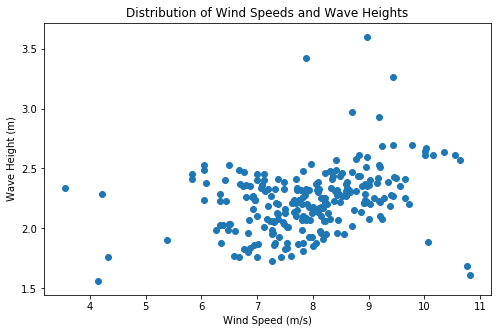

In [21]:
fig, ax = plt.subplots(figsize=(8,5))

ax.scatter(wind, wave)

ax.set_title('Distribution of Wind Speeds and Wave Heights')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')

plt.show()

There appears to be a slight correlation between wind speed and wave height; when the wind speed increases the wave height tends to increase.

## Bullet Point 2

The function used to calculate $r_{xy}$ (named r_xy) is defined in the section "Get Correlation Coefficient," The function used for confidence interval information (named diff_than_zero) is defined in the section "Get Confidence Interval Information."

In [22]:
corr_coef = r_xy(wind, wave) 
print('The correlation coefficient is {}'.format(corr_coef))

The correlation coefficient is 0.3206244479377164


We can compute the value of 

$$\frac{\sqrt{N-3}}{2}\ln\left( \frac{1+r_{xy}}{1-r_{xy}} \right) $$

using our function diff_than_zero. We are looking for 95% confidence so we input this into our function.

In [23]:
diff_than_zero(wind, wave, 0.95)

(5.083869560700614, True)

It follows that we can claim the data have a non zero correlation coefficient with 95% certainty.

## Bullet Point 3

Now we calculate a linear regression line using functions defined in the section "Parameters for Linear Fit." It is crucial to note that analysis past this point <i> assumes that wind speed is the indepedent variable and wave height is the dependent variable. </i>

In [24]:
a, b = get_slope_params(wind, wave)
a_err, b_err = get_slope_params_uncertainties(wind, wave, 0.95)

Our linear regression line is given by

$$\widetilde{y}=a+bx $$

where $x$ is our wind speed data and $\widetilde{y}$ is our approximate wave height data. $a$ and $b$ are given by

In [25]:
print('a = {} m'.format(a))
print('b = {} s'.format(b))

a = 1.6253867451763606 m
b = 0.07631780426872134 s


A 95 percent confidence interval for b is given by $(b- \delta b, b+\delta b)$ as displated below

In [26]:
print('95% Confidence level for b: ({}, {})'.format(b-b_err, b+b_err))

95% Confidence level for b: (0.047342339301964076, 0.1052932692354786)


## Bullet Point 4

We now proceed to add this linear regression line to our plot.

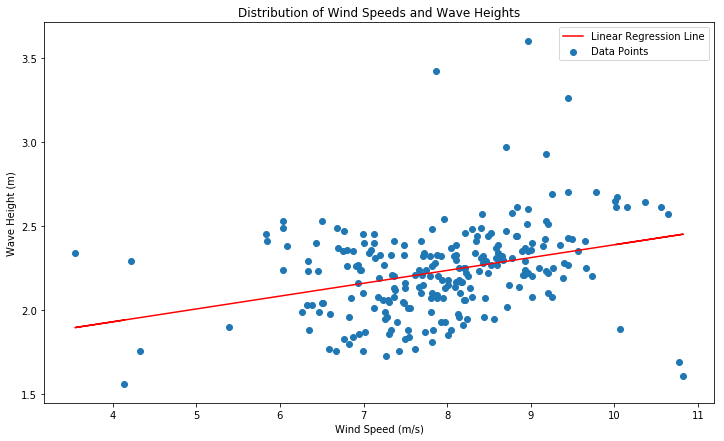

In [27]:
wave_fit = a+b*wind

fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(wind, wave, label='Data Points')
ax.plot(wind, wave_fit, color='r', label='Linear Regression Line')

ax.set_title('Distribution of Wind Speeds and Wave Heights')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')
ax.legend(loc='best')

plt.show()

## Bullet Point 5

Lets now add the linear regression lines with the errors.

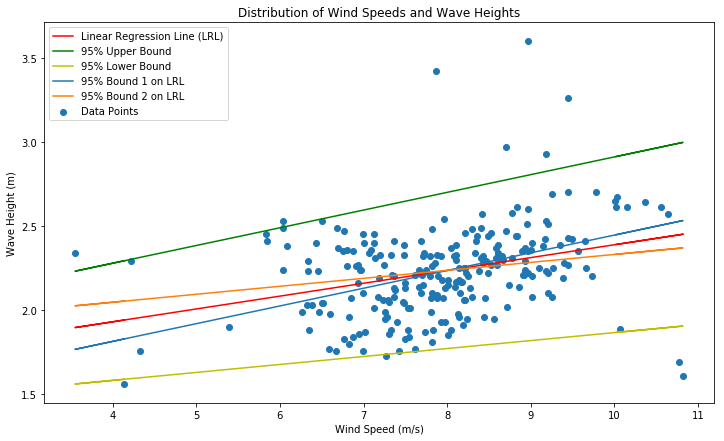

In [28]:
wave_fit = a+b*wind
wave_fit_upr = (a+del_a)+(b+del_b)*wind
wave_fit_lwr = (a-del_a)+(b-del_b)*wind
wave_fit_LRL_upr = (a-del_a)+(b+del_b)*wind
wave_fit_LRL_lwr = (a+del_a)+(b-del_b)*wind

fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(wind, wave, label='Data Points')
ax.plot(wind, wave_fit, color='r', label='Linear Regression Line (LRL)')
ax.plot(wind, wave_fit_upr, color='g', label='95% Upper Bound')
ax.plot(wind, wave_fit_lwr, color='y', label='95% Lower Bound')
ax.plot(wind, wave_fit_LRL_upr, label='95% Bound 1 on LRL')
ax.plot(wind, wave_fit_LRL_lwr, label='95% Bound 2 on LRL')

ax.set_title('Distribution of Wind Speeds and Wave Heights')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')
ax.legend(loc='best')

plt.show()

## Bullet Point 6

Now we add the lines with only the uncertainty on $b$

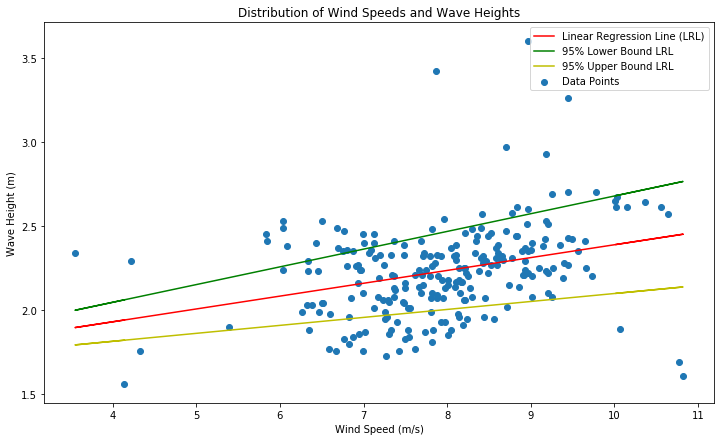

In [29]:
wave_fit = a+b*wind
wave_fit_upr = a+(b+del_b)*wind
wave_fit_lwr = a+(b-del_b)*wind

fig, ax = plt.subplots(figsize=(12,7))

ax.scatter(wind, wave, label='Data Points')
ax.plot(wind, wave_fit, color='r', label='Linear Regression Line (LRL)')
ax.plot(wind, wave_fit_upr, color='g', label='95% Lower Bound LRL')
ax.plot(wind, wave_fit_lwr, color='y', label='95% Upper Bound LRL')

ax.set_title('Distribution of Wind Speeds and Wave Heights')
ax.set_xlabel('Wind Speed (m/s)')
ax.set_ylabel('Wave Height (m)')
ax.legend(loc='best')

plt.show()

## Bullet Point 7

We can use the uncertainties on $a$ and $b$ to calculate a range of wave heights at any wind speed (in this range) with 95% certainty. 

In [30]:
wind_speed = 10

interval = [(a-del_a)+(b-del_b)*wind_speed, (a+del_a)+(b+del_b)*wind_speed]
print(interval)

[1.8665386338344578, 2.91059094189269]


Hence at a wave speed of 10m/s, we can expect the wave height to be within the range (1.87m, 2.91m) at about 95% certainty.